In [20]:
# ==============================================================================
# PROYECTO FINAL: MINERÍA DE DATOS CON PYTHON (SCRIPT COMPLETO)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from pygam import LogisticGAM, s, f
import warnings

# Configuración visual
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [21]:
# ------------------------------------------------------------------------------
# 1. CARGA Y PREPARACIÓN INICIAL
# ------------------------------------------------------------------------------
print("--- 1. CARGANDO DATOS ---")
df = pd.read_csv('bank+marketing/bank/bank-full.csv', sep=';')

# Transformar variable objetivo (yes/no -> 1/0)
df['target'] = df['y'].map({'yes': 1, 'no': 0})
df = df.drop('y', axis=1)

--- 1. CARGANDO DATOS ---


Generando Gráfico 1: Distribución de la variable objetivo...


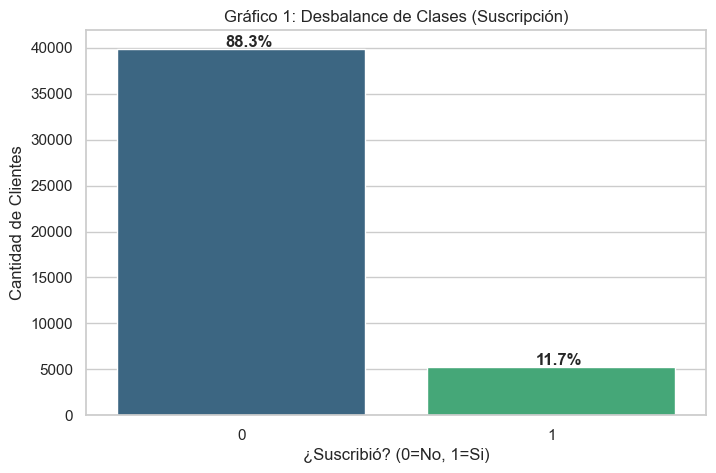

In [22]:
# ------------------------------------------------------------------------------
# 2. GRÁFICO 1: ANÁLISIS EXPLORATORIO (EDA) - Para Diapositiva 3
# ------------------------------------------------------------------------------
print("Generando Gráfico 1: Distribución de la variable objetivo...")
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df, palette='viridis')
plt.title('Gráfico 1: Desbalance de Clases (Suscripción)')
plt.xlabel('¿Suscribió? (0=No, 1=Si)')
plt.ylabel('Cantidad de Clientes')

# Agregar porcentajes a las barras
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + 150
    ax.annotate(percentage, (x, y), size=12, weight='bold')
plt.show()

In [23]:
# ------------------------------------------------------------------------------
# 3. TRANSFORMACIÓN (FEATURE ENGINEERING)
# ------------------------------------------------------------------------------
print("\n--- 3. TRANSFORMANDO DATOS ---")
# Corrección de 'pdays' (-1 significa no contactado)
df['fue_contactado_antes'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1)

# One-Hot Encoding
cols_texto = df.select_dtypes(include=['object']).columns
df_final = pd.get_dummies(df, columns=cols_texto, drop_first=True)
print(f"Dimensiones finales: {df_final.shape}")

# Escalado (Necesario para PCA y Clustering)
X = df_final.drop('target', axis=1)
y = df_final['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


--- 3. TRANSFORMANDO DATOS ---
Dimensiones finales: (45211, 44)


Generando Gráfico 2: PCA...


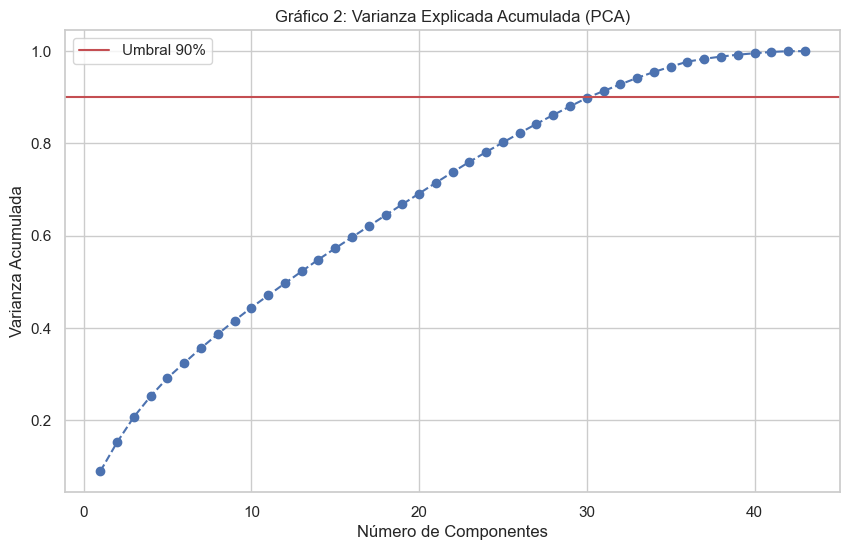

-> Se necesitan 31 componentes para explicar el 90% de la varianza.


In [24]:
# ------------------------------------------------------------------------------
# 4. GRÁFICO 2: PCA (VARIANZA ACUMULADA) - Para Diapositiva 5
# ------------------------------------------------------------------------------
print("Generando Gráfico 2: PCA...")
pca = PCA()
pca.fit(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Gráfico 2: Varianza Explicada Acumulada (PCA)')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.axhline(y=0.90, color='r', linestyle='-', label='Umbral 90%')
plt.legend()
plt.grid(True)
plt.show()

k_pca = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.90) + 1
print(f"-> Se necesitan {k_pca} componentes para explicar el 90% de la varianza.")

Generando Gráfico 3: Método del Codo...


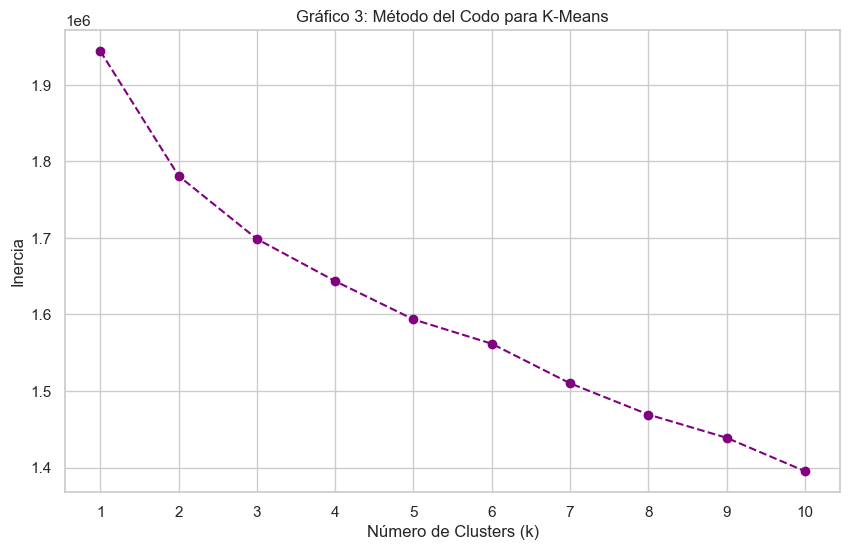


--- PERFIL DE LOS CLUSTERS ENCONTRADOS ---


,age,balance,campaign,target
Cluster,,,,
0,40.950703,1556.688348,2.055959,0.230620
1,39.821217,1138.385162,2.693702,0.055441
2,41.786815,1457.428284,3.097311,0.119367


In [25]:
# ------------------------------------------------------------------------------
# 5. GRÁFICO 3: MÉTODO DEL CODO (CLUSTERING) - Para Diapositiva 6
# ------------------------------------------------------------------------------
print("Generando Gráfico 3: Método del Codo...")
inercia = []
rango_k = range(1, 11)
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercia, marker='o', linestyle='--', color='purple')
plt.title('Gráfico 3: Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

# Aplicar K-Means con k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['Cluster'] = kmeans_final.fit_predict(X_scaled)

print("\n--- PERFIL DE LOS CLUSTERS ENCONTRADOS ---")
display(df_final[['age', 'balance', 'campaign', 'target', 'Cluster']].groupby('Cluster').mean())

In [26]:
# ------------------------------------------------------------------------------
# 6. MODELOS SUPERVISADOS (RF, GAM, LOGREG) - Para Diapositiva 7
# ------------------------------------------------------------------------------
print("\n--- 6. ENTRENANDO MODELOS (Esto puede tardar un poco) ---")
X_model = df_final.drop(['target', 'Cluster'], axis=1)
y_model = df_final['target']

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.3, random_state=42, stratify=y_model
)

# A. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
roc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# B. GAM (Requisito del curso)
gam = LogisticGAM(n_splines=10).fit(X_train.values, y_train.values)
roc_gam = roc_auc_score(y_test, gam.predict_proba(X_test.values))

# C. Regresión Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
roc_log = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print(f"\nRESULTADOS FINALES (ROC-AUC):")
print(f"1. Random Forest:      {roc_rf:.4f}")
print(f"2. GAM (pygam):        {roc_gam:.4f}")
print(f"3. Regresión Logística:{roc_log:.4f}")


--- 6. ENTRENANDO MODELOS (Esto puede tardar un poco) ---

RESULTADOS FINALES (ROC-AUC):
1. Random Forest:      0.9250
2. GAM (pygam):        0.9121
3. Regresión Logística:0.8949


Generando Gráfico 4: Importancia de Variables...


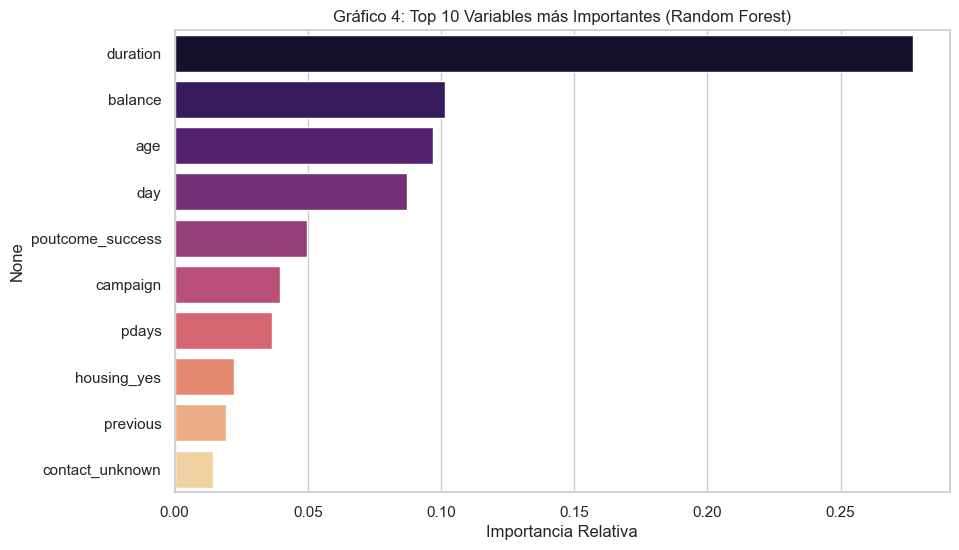

In [27]:
# ------------------------------------------------------------------------------
# 7. GRÁFICO 4: IMPORTANCIA DE VARIABLES (BONUS)
# ------------------------------------------------------------------------------
print("Generando Gráfico 4: Importancia de Variables...")
plt.figure(figsize=(10, 6))
importancias = pd.Series(rf.feature_importances_, index=X_model.columns).sort_values(ascending=False).head(10)
sns.barplot(x=importancias.values, y=importancias.index, palette='magma')
plt.title('Gráfico 4: Top 10 Variables más Importantes (Random Forest)')
plt.xlabel('Importancia Relativa')
plt.show()